In [1]:
cd kwPWRidge

/home/mattyshen/kwPWRidge


Best alpha: 1, Best bandwidth: 0.05


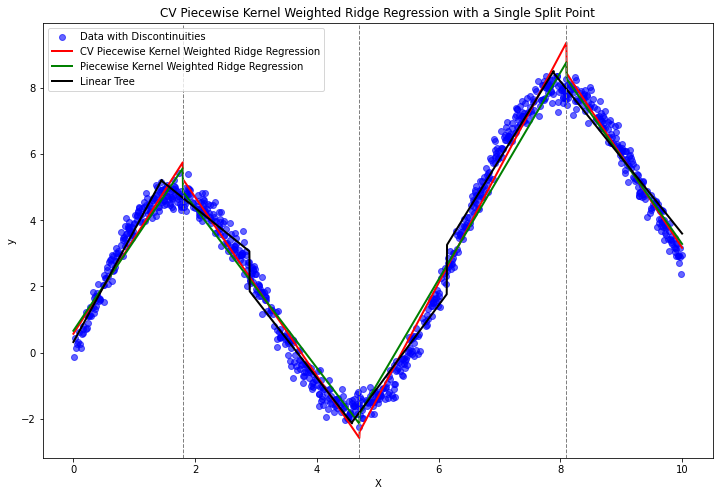

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from itertools import product


from sklearn.model_selection import train_test_split

def exp_kernel(center, bandwidth, X):
    return np.exp(-((X - center) ** 2) / (2 * bandwidth ** 2))

def abs_kernel(center, bandwidth, X):
    return np.exp(-(np.abs(X - center)) / (2 * bandwidth ** 2))

class kwPWRidgeRegressor:
    def __init__(self, alpha=0, bandwidth=None, kernel_func = exp_kernel):
        self.alpha = alpha
        self.bandwidth = bandwidth
        self.kernel = kernel_func
        self.models = []
        self.kernel_weights = []

    def fit(self, X, y, split_points):
        X, y = np.array(X), np.array(y)
        
        self.split_points = split_points.copy()
        self.split_points.extend([-np.inf, np.inf])
        self.split_points = sorted(list(set(self.split_points)))
        for i in range(len(self.split_points) - 1):
            sr_mask = (X >= self.split_points[max(i - 1, 0)]) & (X <= self.split_points[min(i + 2, len(self.split_points)-1)])
            X_sr, y_sr = X[sr_mask], y[sr_mask]
            r_mask = (X_sr >= self.split_points[i]) & (X_sr <= self.split_points[i + 1])
            X_r, y_r = X_sr[r_mask], y_sr[r_mask]

            if len(X_r) > 0:
                center = np.mean(X_r) #(self.split_points[i] + self.split_points[i + 1]) / 2
                bandwidth = (np.std(X_r) + 0.01) if self.bandwidth is None else self.bandwidth
                kernel_weights = self.kernel(center, bandwidth, X_sr)
                kernel_weights[r_mask] = 1.0
                self.kernel_weights.append(kernel_weights)

                model = Ridge(alpha=self.alpha)
                model.fit(X_sr.reshape(-1, 1), y_sr, sample_weight=kernel_weights)
                self.models.append(model)
            else:
                self.models.append(None)
                
        self.split_points[0] = -np.inf
        self.split_points[-1] = np.inf

    def predict(self, X):
        X = np.array(X)
        y_pred = np.zeros(len(X))
        for i in range(len(self.split_points) - 1):
            mask = (X >= self.split_points[i]) & (X < self.split_points[i + 1])
            if self.models[i] is not None and np.sum(mask) > 0:
                y_pred[mask] = self.models[i].predict(X[mask].reshape(-1, 1))
        return y_pred

class kwPWRidgeRegressorCV:
    def __init__(self, alphas=[0.1, 1, 10, 100], bandwidths=[1, 10, 100], cv=3, random_state=42):
        self.alphas = alphas
        self.bandwidths = bandwidths
        self.cv = cv
        self.random_state = random_state
        self.best_alpha = None
        self.best_bandwidth = None
        self.model = None
        self.scores = []

    def fit(self, X, y, split_points):
        X, y = np.array(X), np.array(y)
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=self.random_state)
        
        results = []

        for alpha, bandwidth in product(self.alphas, self.bandwidths):
            fold_scores = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model = kwPWRidgeRegressor(alpha=alpha, bandwidth=bandwidth)
                model.fit(X_train, y_train, split_points)
                y_pred = model.predict(X_val)
                score = r2_score(y_val, y_pred)
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)
            results.append((avg_score, alpha, bandwidth))
            self.scores.append((alpha, bandwidth, avg_score))

        best_score_index = np.argmax([result[0] for result in results])
        best_score, best_alpha, best_bandwidth = results[best_score_index]
        self.best_alpha = best_alpha
        self.best_bandwidth = best_bandwidth

        self.model = kwPWRidgeRegressor(alpha=self.best_alpha, bandwidth=self.best_bandwidth)
        self.model.fit(X, y, split_points)

    def predict(self, X):
        if self.model is not None:
            return self.model.predict(X)
        else:
            raise Exception("The model has not been fitted yet.")

if __name__ == "__main__":
    #np.random.seed(42)
    from models.linear_tree import LinearTree
    X = np.linspace(0, 10, 2000)
    y = 4 * np.sin(X) + 0.5 * X + np.random.normal(0, 0.25, size=2000)

    # y[50:60] += 15
    # y[120:130] -= 10
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    split_points = [1.8, 4.7, 8.1]
    alphas = [1, 10, 100]
    bandwidths = [i for i in np.arange(0.05, 1, 0.05)]
    cv_model = kwPWRidgeRegressorCV(alphas, bandwidths)
    model = kwPWRidgeRegressor(1)
    lt = LinearTree(max_depth = 4, min_r2_gain = 0.1, alpha = 0.1, lam = 10, depth_shrink= 3)
    cv_model.fit(X_train, y_train, split_points)
    model.fit(X_train, y_train, split_points)
    lt.fit(X_train.reshape(-1, 1), y_train)
    print(f'Best alpha: {cv_model.best_alpha}, Best bandwidth: {cv_model.best_bandwidth}')
    y_pred_cv = cv_model.predict(X_test)
    y_pred = model.predict(X_test)

    # Visualization
    plt.figure(figsize=(12, 8))
    plt.scatter(X_test, y_test, color='blue', label='Data with Discontinuities', alpha=0.6)
    # plt.scatter(X_test, y_pred_cv, color='red', label='CV Piecewise Kernel Weighted Ridge Regression', linewidth=2)
    # plt.scatter(X_test, y_pred, color='green', label='Piecewise Kernel Weighted Ridge Regression', linewidth=2)
    
    plt.plot(X, cv_model.predict(X), color='red', label='CV Piecewise Kernel Weighted Ridge Regression', linewidth=2)
    plt.plot(X, model.predict(X), color='green', label='Piecewise Kernel Weighted Ridge Regression', linewidth=2)
    plt.plot(X, lt.predict(X), color='black', label='Linear Tree', linewidth=2)
    
    for split in split_points:
        plt.axvline(x=split, color='grey', linestyle='--', linewidth=1)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('CV Piecewise Kernel Weighted Ridge Regression with a Single Split Point')
    plt.legend()
    plt.show()

             X         Y
0     0.000000  0.000000
1     0.126295  0.125960
2     0.252590  0.249913
3     0.378886  0.369885
4     0.505181  0.483966
..         ...       ...
195  24.627561 -6.483966
196  24.753856 -6.369885
197  24.880151 -6.249913
198  25.006446 -6.125960
199  25.132741 -6.000000

[200 rows x 2 columns]


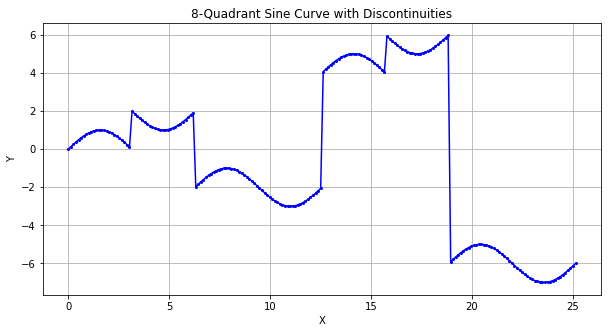

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameters
num_points_per_quad = 25  # Number of points per quadrant for a smooth curve
num_quadrants = 8  # Total quadrants
x_values = np.linspace(0, num_quadrants * np.pi, num_quadrants * num_points_per_quad)  # Spread over 8 quadrants

# Generate sine curve
y_values = np.sin(x_values)

# Apply increasing and decreasing patterns
for i in range(num_quadrants):
    # Determine if it's an increasing or decreasing segment
    if i % 4 < 2:  # Increase for quads 1-2 and 5-6
        y_values[i * num_points_per_quad:(i + 1) * num_points_per_quad] += i  # Adjust to simulate shifting
    else:  # Decrease for quads 3-4 and 7-8
        y_values[i * num_points_per_quad:(i + 1) * num_points_per_quad] -= i  # Adjust to simulate shifting

    # Shift for discontinuity on the second quadrant of each pair
    if i % 2 == 1:
        y_values[i * num_points_per_quad:(i + 1) * num_points_per_quad] += 1

# Create DataFrame for the dataset
data = pd.DataFrame({
    "X": x_values,
    "Y": y_values
})

# Display the dataset
print(data)

# Plot the dataset to visualize
plt.figure(figsize=(10, 5))
plt.plot(data["X"], data["Y"], marker='o', markersize=2, linestyle='-', color='b')
plt.title("8-Quadrant Sine Curve with Discontinuities")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()


In [18]:
lt2 = LinearTree(max_depth = 7,  min_r2_gain = 0, alpha = 0.1, lam = 10, depth_shrink= 4)
lt2.fit(data['X'].to_numpy().reshape(-1, 1), data['Y'].to_numpy().reshape(-1, 1))

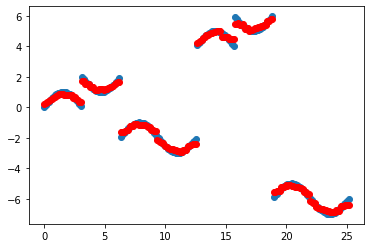

In [19]:
plt.scatter(data['X'].to_numpy().reshape(-1, 1), data['Y'].to_numpy().reshape(-1, 1))
plt.scatter(data['X'].to_numpy().reshape(-1, 1), lt2.predict(data['X'].to_numpy().reshape(-1, 1)), color = 'red')

In [6]:
r2_score(cv_model.predict(X_test), y_test)

0.9762913556234543

In [7]:
r2_score(model.predict(X_test), y_test)

0.9673755816054186

In [8]:
r2_score(lt.predict(X_test), y_test)

0.9823130701129971

In [9]:
pwd

'/home/mattyshen/kwPWRidge'

In [10]:
cd kwPWRidge

[Errno 2] No such file or directory: 'kwPWRidge'
/home/mattyshen/kwPWRidge


In [11]:
len(np.ones(5).reshape(-1, 1))

5

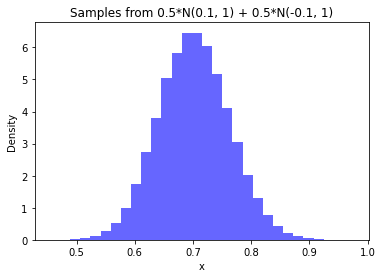

In [12]:
import numpy as np

def sample_mixture_of_gaussians(theta, n_samples=1):
    samples = []
    for _ in range(n_samples):
        # Step 1: Choose which Gaussian to sample from (50% chance each)
        if np.random.rand() < 0.5:
            # Sample from N(theta, 1)
            sample = np.random.normal(theta, 1)
        else:
            # Sample from N(-theta, 1)
            sample = np.random.normal(-theta, 1)
        
        samples.append(sample)
    return np.array(samples)

# Parameters
theta = 0.1  # Set theta to your desired value in [0, ∞)
n_samples = 100  # Number of samples to generate

# Generate samples
samples = []
for i in range(100000):
    samples.append(np.mean(np.abs(sample_mixture_of_gaussians(theta, n_samples))) - theta)

# Optional: visualize the samples
import matplotlib.pyplot as plt

plt.hist(samples, bins=30, density=True, alpha=0.6, color='b')
plt.title(f'Samples from 0.5*N({theta}, 1) + 0.5*N(-{theta}, 1)')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()


In [13]:
np.mean(samples)

0.701873947691942